# Import Section

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Dataset Processing

In [34]:
positive_reviews = pd.read_csv("dataset\\positive.csv")
negative_reviews = pd.read_csv("dataset\\negative.csv")

positive_reviews['label'] = 1
negative_reviews['label'] = 0
data = pd.concat([positive_reviews, negative_reviews]).reset_index(drop=True)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['0'], data['label'], test_size=0.2, stratify=data['label'], random_state=42
)

**_Reset indices to avoid KeyError during data access_**

In [35]:
train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

**_Tokenization_**

In [36]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['0'])
sequences = tokenizer.texts_to_sequences(data['0'])

**_Padding_**

In [37]:
max_length = 256
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = data['label'].values

**_Data Split_**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

**_Hyperparameters_**

In [39]:
embedding_dim =128
lstm_units = 128
dropout_rate = 0.6
learning_rate = 0.0001 

**_Model Definition_**

In [40]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(dropout_rate),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))  
])

**_Compilation_**

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**_Structure_**

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 128)          2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

# Train

In [43]:
batch_size = 32
epochs = 100

with tf.device('/GPU:0'):
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
    )
    early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    min_delta=0.001    
    )
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=[reduce_lr, early_stopping]
    )


Epoch 1/100
280/280 [==============================] - 12s 36ms/step - loss: 1.1348 - accuracy: 0.5049 - val_loss: 1.0183 - val_accuracy: 0.5339 - lr: 1.0000e-04
Epoch 2/100
280/280 [==============================] - 9s 34ms/step - loss: 0.9050 - accuracy: 0.6401 - val_loss: 0.8466 - val_accuracy: 0.6946 - lr: 1.0000e-04
Epoch 3/100
280/280 [==============================] - 10s 35ms/step - loss: 0.6324 - accuracy: 0.8189 - val_loss: 0.4517 - val_accuracy: 0.8777 - lr: 1.0000e-04
Epoch 4/100
280/280 [==============================] - 10s 34ms/step - loss: 0.5186 - accuracy: 0.8471 - val_loss: 0.4318 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 5/100
280/280 [==============================] - 10s 37ms/step - loss: 0.5007 - accuracy: 0.8508 - val_loss: 0.3384 - val_accuracy: 0.9049 - lr: 1.0000e-04
Epoch 6/100
280/280 [==============================] - 10s 36ms/step - loss: 0.2640 - accuracy: 0.9531 - val_loss: 0.3040 - val_accuracy: 0.9170 - lr: 1.0000e-04
Epoch 7/100
280/280 [========

# Test

**_Prediction_**

In [44]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

88/88 [==============================] - 1s 8ms/step


**_Metrics_**

In [45]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9214
Precision: 0.9158
Recall: 0.9300
F1-score: 0.9229


# Visualization

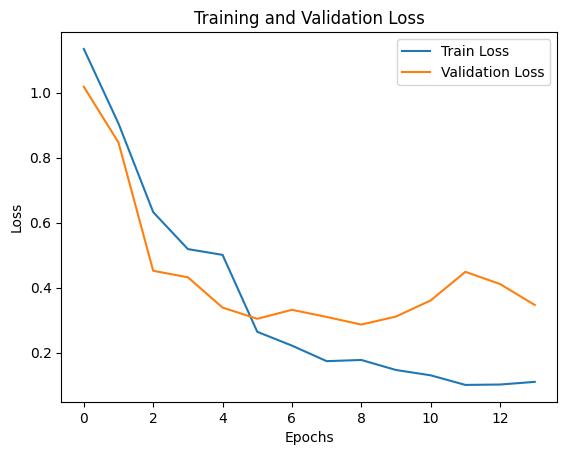

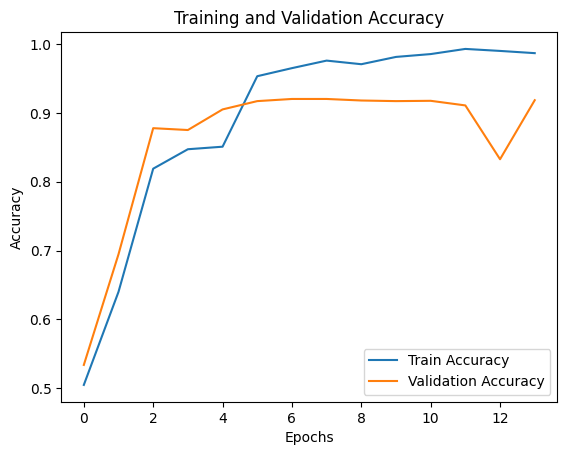

In [46]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
